Port of the `rl_util` notebook from the paper [Understanding RL vision](https://distill.pub/2020/understanding-rl-vision).
Ported to be compatible with `lucent` and my port of the rl-vision code to lucent, which is in this repo.

# Setup

n/a

# Import utilities and load data

First let's import the utilities.


In [62]:
# Interactive mode
%load_ext autoreload
%autoreload 2

from pathlib import Path

from imitation.data.rollout import flatten_trajectories
from imitation.scripts.common import demonstrations
from lucent.misc.io import show
from lucent.modelzoo.util import get_model_layers

import numpy as np
import torch as th
from collections import OrderedDict
# from lucid.modelzoo.vision_base import Model
# from lucid.scratch.rl_util import *
# get_abbreviator defined during setup
from reward_preprocessing.ext.notebook_util import CategoricalPolicyGM, ImpalaModel, get_abbreviator
from reward_preprocessing.vis.reward_vis import LayerNMF
from reward_preprocessing.vis.util import zoom_to

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's load the data for the model we want to analyze. We will analyze our RL agent trained on coinrun.

In [63]:
model_path = "~/out/chai/interpret/policies/coinrun7-gm/model_200015872.pth"
trajectories_path = "~/out/chai/interpret/expert-rollouts/coinrun2/001-60eps.npz"

device = "cuda" if th.cuda.is_available() else "cpu"

model_state_dict = th.load(Path(model_path).expanduser(), device)["model_state_dict"]

embedder = ImpalaModel(in_channels=3)
model = CategoricalPolicyGM(embedder=embedder, action_size=model_state_dict["fc_policy.weight"].shape[0])
# Load data
model.load_state_dict(model_state_dict)

value_function_name = 'fc_value'

# Load trajectories for dataset visualization.
trajectories = demonstrations.load_expert_trajs(str(Path(trajectories_path).expanduser()), n_expert_demos=None)
trajectories = flatten_trajectories(trajectories)

# Get observations from trajectories.
observations = trajectories.obs
# Imitation uses h,w,ch, lucent uses channels first (unlike lucid, which uses channels last).
observations = np.transpose(observations, (0, 3, 1, 2))

layer_names = get_model_layers(model)
abbreviator = get_abbreviator(layer_names)
layer_names = OrderedDict(
    [(name[abbreviator], name) for name in layer_names]
)


Let's explain each of these variables:

- `model: lucid.modelzoo.vision_base.Model` &ndash; Lucid model
- `policy_logits_name: str` &ndash; name of the policy head tensor in the model
- `value_function_name: str` &ndash; name of the value head tensor in the model
- `env_name: str` &ndash; name of the environment
- `gae_gamma: float` &ndash; generalized advantage estimation hyperparameter $\gamma$ used to train the model
- `gae_lambda: float` &ndash; generalized advantage estimation hyperparameter $\lambda$ used to train the model
- `action_combos: List[Tuple[str]]` &ndash; which combination of keys each integer action corresponds to
- `observations: np.ndarray` &ndash; batch &times; channels &times; height &times; width float array of observations sampled infrequently from the agent playing the game, intended to be used for NMF
- `trajectories: Dict[str, np.ndarray]` &ndash; dictionary from contiguous trajectories of the agent playing the game with the following keys:
    - `observations` &ndash; trajectories &times; timesteps &times; channels &times; height &times; width float array of observations
    - `actions` &ndash; trajectories &times; timesteps array of integer actions
    - `rewards` &ndash; trajectories &times; timesteps array of float rewards
    - `firsts` &ndash; trajectories &times; timesteps array of booleans specifying whether the timestep was the first in the episode
- `layer_names: OrderedDict[str, str]` &ndash; mapping from the abbreviated names to the full names of the activation tensors of the convolutional layers in the model

Let's print the abbreviated layer names that were found.

In [64]:
print(", ".join(layer_names.keys()))
print(model)

embedder, embedder_block1, embedder_block1_conv, embedder_block1_res1, embedder_block1_res1_conv1, embedder_block1_res1_conv2, embedder_block1_res2, embedder_block1_res2_conv1, embedder_block1_res2_conv2, embedder_block2, embedder_block2_conv, embedder_block2_res1, embedder_block2_res1_conv1, embedder_block2_res1_conv2, embedder_block2_res2, embedder_block2_res2_conv1, embedder_block2_res2_conv2, embedder_block3, embedder_block3_conv, embedder_block3_res1, embedder_block3_res1_conv1, embedder_block3_res1_conv2, embedder_block3_res2, embedder_block3_res2_conv1, embedder_block3_res2_conv2, embedder_fc, embedder_relu_after_convs, fc_policy, fc_value
CategoricalPolicyGM(
  (embedder): ImpalaModel(
    (block1): ImpalaBlock(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (res1): ResidualBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

The `zoom_to` and `show` utilities are useful for displaying observations and visualizations.


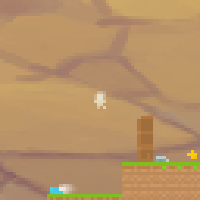
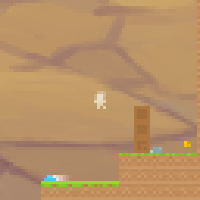
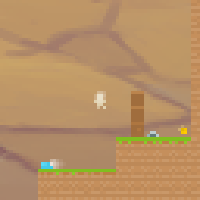
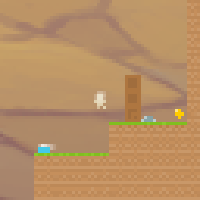
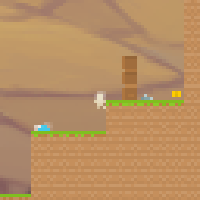
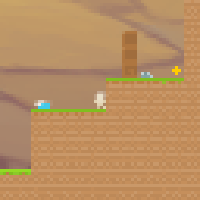
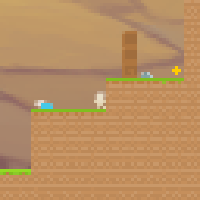
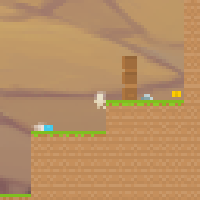

In [65]:
show(zoom_to(trajectories.obs[:8], 200))

# Dimensionality reduction and feature visualization

The `LayerNMF` utility can be used to apply NMF dimensionality reduction to obtain directions in activation space, and then to use feature visualization (either gradient-based or dataset example-based) to visualize those directions.

Passing `attr_layer_name=value_function_name` causes NMF to be applied to value function attributions. If we did not pass this, NMF would instead be applied to activations.

We use the infrequently-sampled `observations` rather than observations from `trajectories` in order to cover a broader distribution of observations.

In [83]:
model.eval()
layer = 'embedder_relu_after_convs'
# value_function_name = None
# can take a couple of minutes
# for the paper, we use observations[:], but this requires more memory
nmf = LayerNMF(model, layer, observations[:1024], features=4, attr_layer_name=value_function_name)

/home/pavel/anaconda3/envs/interpret-regression/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/pavel/anaconda3/envs/interpret-regression/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return 

The directions in activation space obtained are given by the `channel_dirs` property.

In [67]:
nmf.channel_dirs.shape

torch.Size([4, 32])

We can now visualize these directions in activation space in various ways.

We can apply gradient-based feature visualization using the `vis_traditional` method.

Initial loss: -0.525


100%|██████████| 512/512 [00:07<00:00, 64.15it/s]


Loss at step 512: -2.812



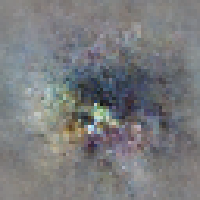
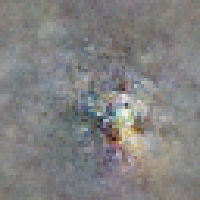
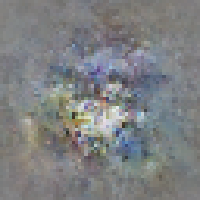
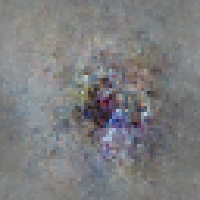

In [86]:
show(zoom_to(nmf.vis_traditional(), 200))

We can apply dataset example-based feature visualization using the `vis_dataset_thumbnail` method. `num_mult` gives the height and width of the grid of patches, and `expand_mult` is a multiplier on the size of each patch.

The strength of the activation for the image from which the patch was taken is given in the alpha (opacity) channel of the visualization (scaled to be at most 1).


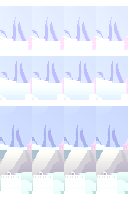
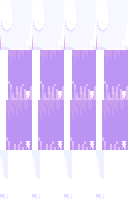
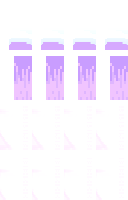
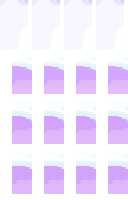

In [91]:
# Show expects channels last, unlike the rest of lucent. Therefore we need to transpose here.
show([zoom_to(nmf.vis_dataset_thumbnail(i, num_mult=4, expand_mult=4, max_rep=np.inf)[0], 200).transpose(1,2,0) for i in range(nmf.features)])

We can apply spatially-aware dataset example-based feature visualization using the `vis_dataset` method. `subdiv_mult` gives the height and width of the grid of patches per activation, and `expand_mult` is again a multiplier on the size of each patch.

Activation strength is again given by opacity, so most of the top and left of the image is transparent since coins do not usually appear in those parts of observations.


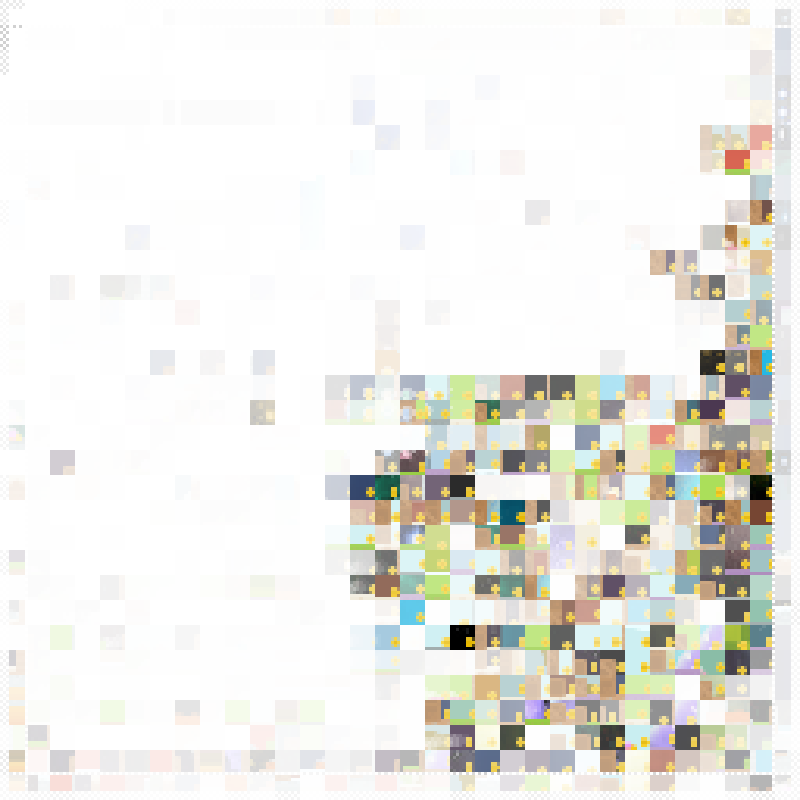

In [14]:
show(zoom_to(nmf.vis_dataset(1, subdiv_mult=1, expand_mult=4)[0], 800))

# Attribution

The `get_acts` utility can be used to get activations. We can use this to get the model's value function for some observations.


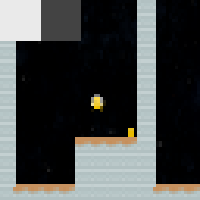
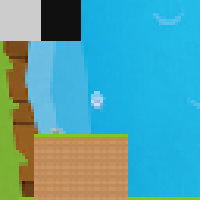
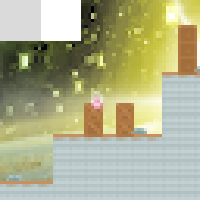
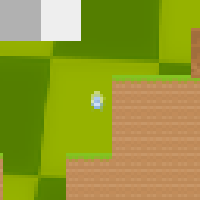
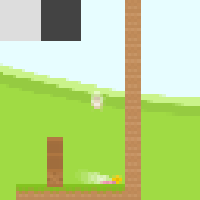
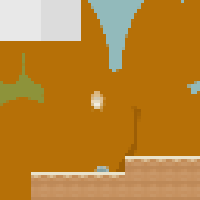
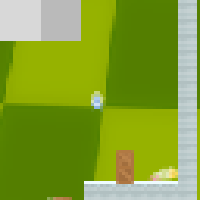
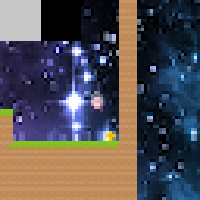

In [15]:
value_functions = get_acts(model, value_function_name, observations[:8])
show(zoom_to(observations[:8], 200), labels=[f"{v:.3f}" for v in value_functions])

The `get_attr` utility can be used to get attributions using the integrated gradients method. The number of steps used for the numerical integration is specified by `integrate_steps`. Here we apply this to some observations from a trajectory.

We pass `value_function_name` in order to get value function attributions. If we passed the name of a tensor with more than one element (such as `policy_logits_name`), then we could use `score_fn` to specify how to reduce that tensor to a single element (note that `score_fn` should not reduce the batch dimension).

In [16]:
traj = trajectories['observations'][0][76:84]
attr = get_attr(model, value_function_name, layer_names['2b'], traj, integrate_steps=10)
attr.shape

(8, 32, 32, 32)

We can apply dimensionality reduction to these attributions using the `LayerNMF` object we generated earlier.

In [17]:
attr_reduced = nmf.transform(np.maximum(attr, 0)) - nmf.transform(np.maximum(-attr, 0))  # transform the positive and negative parts separately
nmf_norms = nmf.channel_dirs.sum(-1)
attr_reduced *= nmf_norms[None, None, None]  # multiply by the norms of the NMF directions, since the magnitudes of the NMF directions are not relevant
attr_reduced /= np.median(attr_reduced.max(axis=(-3, -2, -1)))  # globally normalize by the median max value to make the visualization balanced (a bit of a hack)
attr_reduced.shape

(8, 32, 32, 8)

Here are the observations along with the positive and negative parts of the attributions, which we visualize by assigning a different color to each of the post-NMF channels.

observation



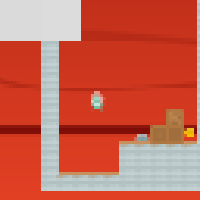
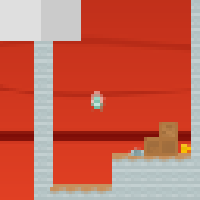
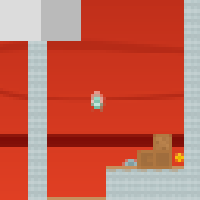
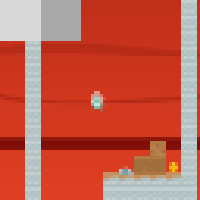
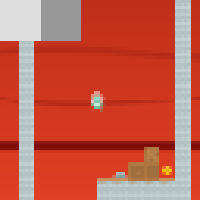
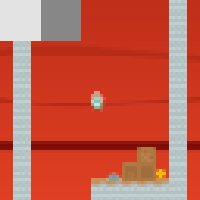
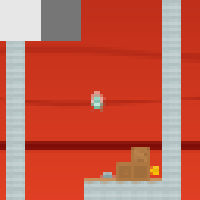
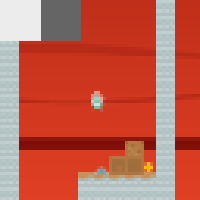

positive attribution



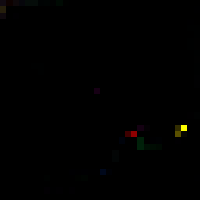
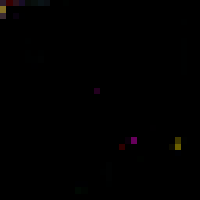
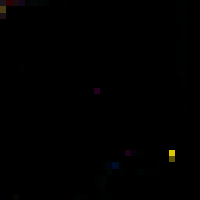
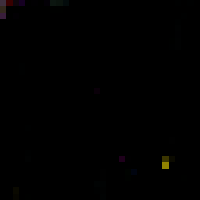
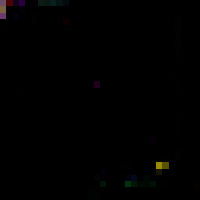
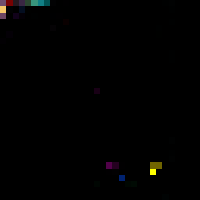
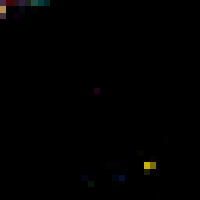
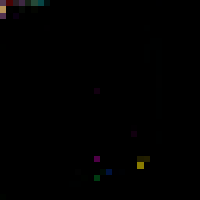

negative attribution



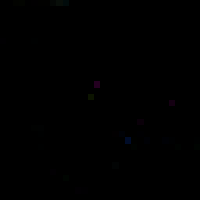
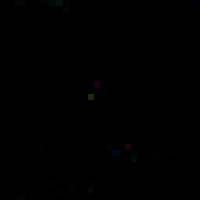
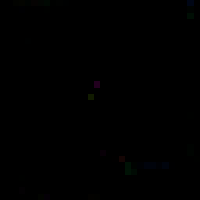
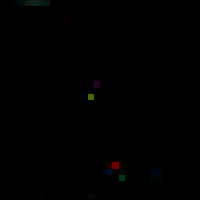
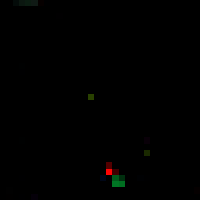
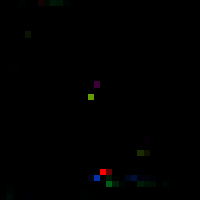
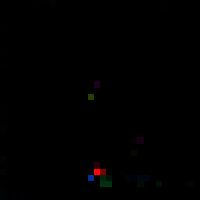
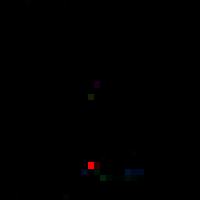

In [18]:
attr_pos = np.maximum(attr_reduced, 0)
attr_neg = np.maximum(-attr_reduced, 0)
print("observation")
show(zoom_to(traj, 200))
print("positive attribution")
show(zoom_to(attr_pos, 200))
print("negative attribution")
show(zoom_to(attr_neg, 200))

We can use the `conv2d` and `norm_filter` utilities to smooth out attribution over nearby spatial positions, so that the amount of visual space taken up can be used to judge attribution strength.

observation



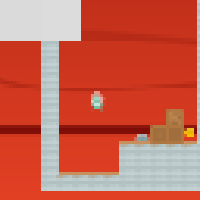
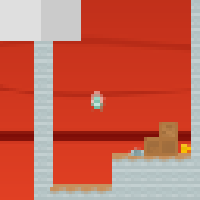
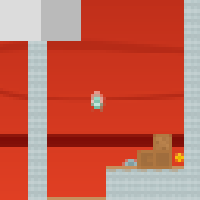
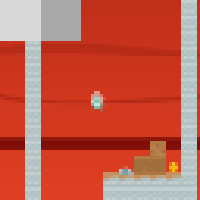
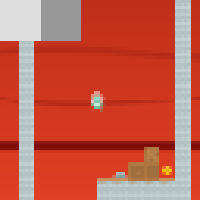
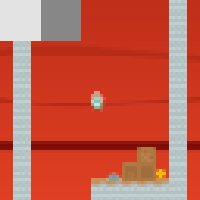
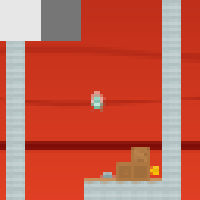
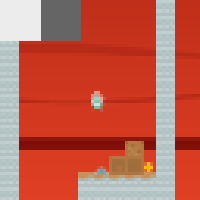

positive attribution



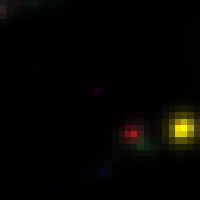
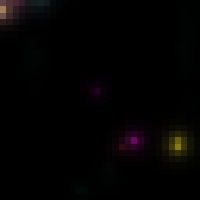
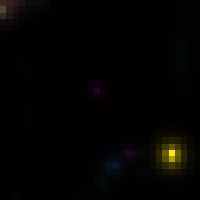
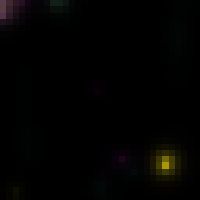
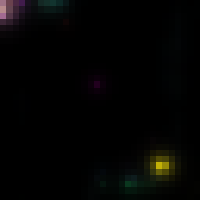
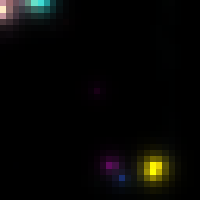
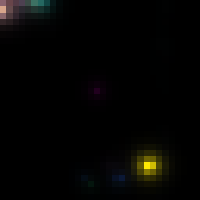
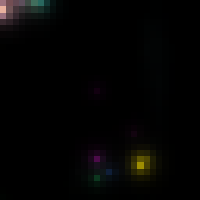

negative attribution



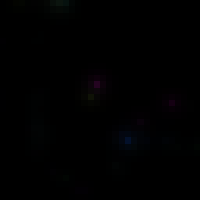
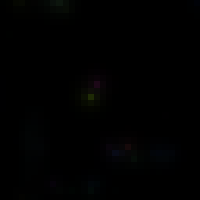
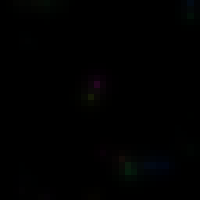
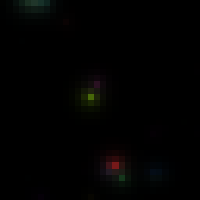
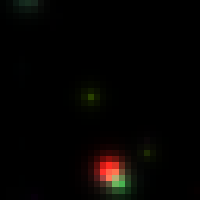
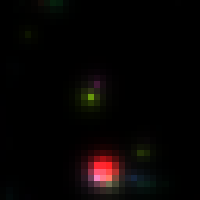
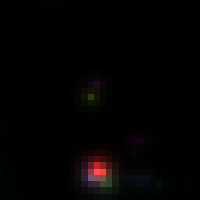
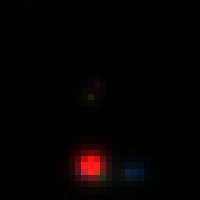

In [19]:
print("observation")
show(zoom_to(traj, 200))
print("positive attribution")
show(zoom_to(conv2d(attr_pos, filter_=norm_filter(15)), 200))
print("negative attribution")
show(zoom_to(conv2d(attr_neg, filter_=norm_filter(15)), 200))

# Model editing

To edit the model in-place, we can use Lucid's `ParameterEditor`.

In [20]:
from copy import deepcopy
from lucid.scratch.parameter_editor import ParameterEditor

edited_model = deepcopy(model)
editor = ParameterEditor(edited_model.graph_def)

To make the model blind to saw obstacles, we can use the first NMF direction. We edit the convolutional kernel of the next layer to make it project out the NMF direction from activations before applying the original kernel.

In [21]:
kernel_name = layer_names["3a"].replace("Relu", "conv2d/kernel")  # name of tensor of convolutional kernel of next layer
kernel = editor[kernel_name]
saw_dir = nmf.channel_dirs[0][None, None, :, None]  # first NMF direction, corresponding to saw obstacle
saw_dir /= np.linalg.norm(saw_dir)
# the kernel is left-multiplied by the activations from the previous layer, so we left-multiply the kernel by the projection matrix
kernel = kernel - saw_dir * (saw_dir * kernel).sum(axis=-2, keepdims=True)  # equivalently: kernel - saw_dir @ saw_dir.transpose((0, 1, 3, 2)) @ kernel
editor[kernel_name] = kernel
# note: this is not quite the same as the edit made for the paper, since we only used 1024 observations for the NMF calculation here

We can use the `get_var` utility to verify that the kernel has been updated.

In [22]:
print(np.linalg.norm(get_var(model, kernel_name)))
print(np.linalg.norm(get_var(edited_model, kernel_name)))

31.603941
30.58285


If we now repeat the attribution visualization from above with the edited model, we see that the red saw obstacle channel has disappeared, while the yellow coin channel remains present.

observation



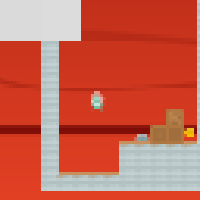
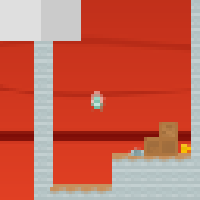
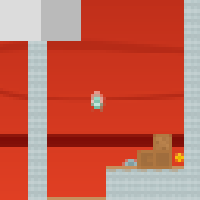
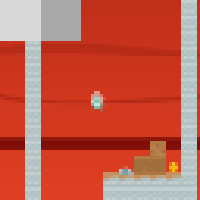
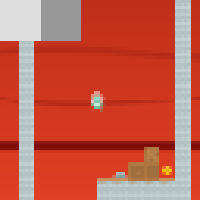
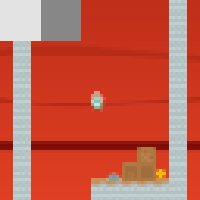
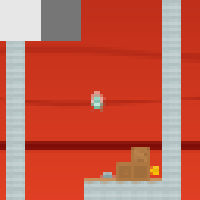
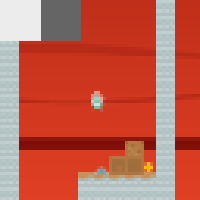

positive attribution



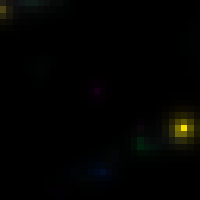
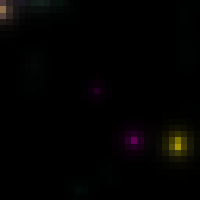
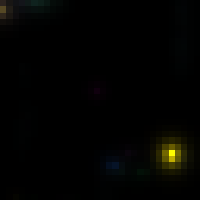
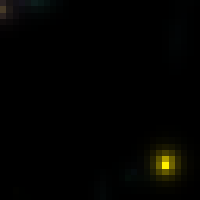
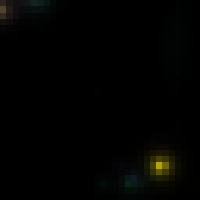
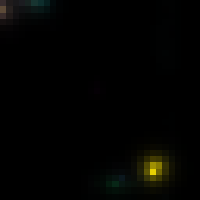
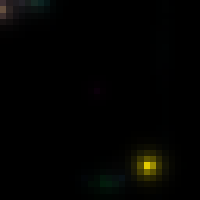
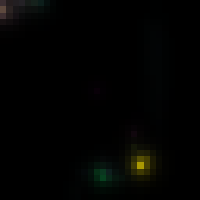

negative attribution



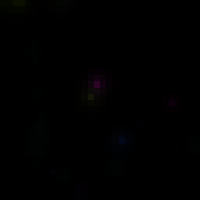
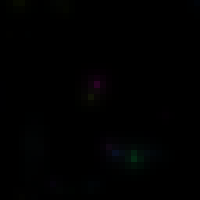
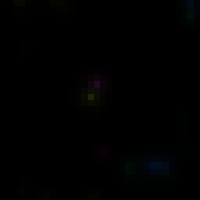
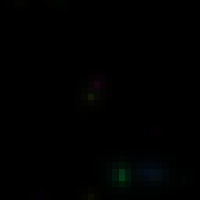
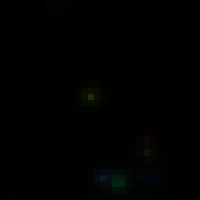
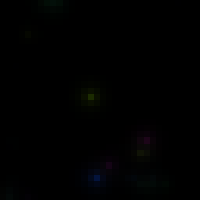
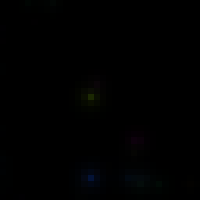
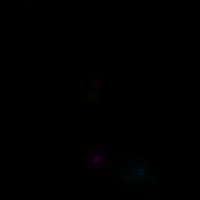

In [23]:
traj = trajectories['observations'][0][76:84]
attr = get_attr(edited_model, value_function_name, layer_names['2b'], traj, integrate_steps=10)
attr_reduced = nmf.transform(np.maximum(attr, 0)) - nmf.transform(np.maximum(-attr, 0))
nmf_norms = nmf.channel_dirs.sum(-1)
attr_reduced *= nmf_norms[None, None, None]
attr_reduced /= np.median(attr_reduced.max(axis=(-3, -2, -1)))
attr_pos = np.maximum(attr_reduced, 0)
attr_neg = np.maximum(-attr_reduced, 0)
print("observation")
show(zoom_to(traj, 200))
print("positive attribution")
show(zoom_to(conv2d(attr_pos, filter_=norm_filter(15)), 200))
print("negative attribution")
show(zoom_to(conv2d(attr_neg, filter_=norm_filter(15)), 200))